In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import string
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')
from tensorflow.keras.layers import Input,Dense, LSTM, Flatten, Bidirectional, GlobalMaxPool1D, GRU
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import os
import keras
# from tensorflow.keras.callbacks import EarlyStopping
# from tensorflow.keras.callbacks import ModelCheckpoint
import datetime
# from keras.layers import Dense
# from keras.layers import Flatten
# from keras.layers import Embedding
from keras.layers import Dropout,SpatialDropout1D
from keras.regularizers import l2
from keras.layers import concatenate, BatchNormalization
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from datetime import time
# from keras.callbacks import TensorBoard, ModelCheckpoint
from nltk.stem import WordNetLemmatizer
from keras.preprocessing import sequence
from keras.initializers import he_normal

from keras.layers import LeakyReLU

import tensorflow_hub as hub
import pydot

In [49]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [50]:
# importing the data

train_df=pd.read_csv('../input/nlp-getting-started/train.csv')
test_df=pd.read_csv('../input/nlp-getting-started/test.csv')

In [51]:
# importing the data

# train_df=pd.read_csv('train.csv')
# test_df=pd.read_csv('test.csv')

In [52]:
train_df=train_df[['text', 'target']]
test_df=test_df[['text']]

In [53]:
train_df.head()

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


## Data Preprocessing 

In [54]:
# ref - https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python
# ref - https://datagy.io/python-remove-punctuation-from-string/#:~:text=One%20of%20the%20easiest%20ways,maketrans()%20method.
# ref - https://www.kaggle.com/code/sudalairajkumar/getting-started-with-text-preprocessing
# ref - https://stackoverflow.com/questions/33404752/removing-emojis-from-a-string-in-python


# Preprocessing steps:
# 1) Converting to lower-case
# 2) Decontracting the text
# 3) Removing URLs
# 4) Removing HTMLs
# 5) Removing special characters
# 6) Removing emojis
# 7) Removing Slangs or chat words
# 8) Removing stopwords
# 9) Lemmatizing the data

In [55]:
# 1 Converting to lower-case
def lowercase(text):
    return text.lower()

# 2 Decontracting the text
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    phrase = re.sub(r"\'cause", " because", phrase)
    phrase = re.sub(r"let\'s", "let us", phrase)

    return phrase

# 3 Removing URLs
def remove_url(text):
    text= re.sub(r'https?://\S+|www\.\S+', '', text)
    return text

# 4 Removing HTMLs
def remove_html(text):
    text=re.sub(r'<.*?>','',text)
    return text

# 5 Removing special characters
punctuations=string.punctuation
def remove_punc(text):
#     return text.translate(str.maketrans('', '', punctuations))
    text=re.sub(r'[^\w\s\d]', '', text)
    text =re.sub(r'[^A-za-z0-9\s]','',text)
    return text
    
# 6 Removing emojis
def remove_emoji(text):
    emoji_pattern = re.compile("["
            u"\U0001F600-\U0001F64F"  # emoticons
            u"\U0001F300-\U0001F5FF"  # symbols & pictographs
            u"\U0001F680-\U0001F6FF"  # transport & map symbols
            u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               "]+", flags=re.UNICODE)
    text=emoji_pattern.sub(r'', text) # no emoji
    return text


In [56]:
# 7 Removing Slangs or chat words
# Converting slangs and chat words like BRB to Be Right Back, FYI to For Your Information
slangs="""AFAIK=As Far As I Know
AFK=Away From Keyboard
ASAP=As Soon As Possible
ATK=At The Keyboard
ATM=At The Moment
A3=Anytime, Anywhere, Anyplace
BAK=Back At Keyboard
BBL=Be Back Later
BBS=Be Back Soon
BFN=Bye For Now
B4N=Bye For Now
BRB=Be Right Back
BRT=Be Right There
BTW=By The Way
B4=Before
B4N=Bye For Now
CU=See You
CUL8R=See You Later
CYA=See You
FAQ=Frequently Asked Questions
FC=Fingers Crossed
FWIW=For What It's Worth
FYI=For Your Information
GAL=Get A Life
GG=Good Game
GN=Good Night
GMTA=Great Minds Think Alike
GR8=Great!
G9=Genius
IC=I See
ICQ=I Seek you (also a chat program)
ILU=ILU: I Love You
IMHO=In My Honest/Humble Opinion
IMO=In My Opinion
IOW=In Other Words
IRL=In Real Life
KISS=Keep It Simple, Stupid
LDR=Long Distance Relationship
LMAO=Laugh My A.. Off
LOL=Laughing Out Loud
LTNS=Long Time No See
L8R=Later
MTE=My Thoughts Exactly
M8=Mate
NRN=No Reply Necessary
OIC=Oh I See
PITA=Pain In The A..
PRT=Party
PRW=Parents Are Watching
QPSA=Que Pasa?
ROFL=Rolling On The Floor Laughing
ROFLOL=Rolling On The Floor Laughing Out Loud
ROTFLMAO=Rolling On The Floor Laughing My A.. Off
SK8=Skate
STATS=Your sex and age
ASL=Age, Sex, Location
THX=Thank You
TTFN=Ta-Ta For Now!
TTYL=Talk To You Later
U=You
U2=You Too
U4E=Yours For Ever
WB=Welcome Back
WTF=What The F...
WTG=Way To Go!
WUF=Where Are You From?
W8=Wait...
7K=Sick:-D Laugher
IG=Instagram
FB=Facebook
PPL=People
R=Are
PC=Computer"""

# Making the dictionary of the above strings
pattern=re.compile('\\n')
slangs=pattern.sub(r'  ',slangs)
slangs_dict={}
for i in slangs.split('  '):
    lst=i.split('=')
    slangs_dict[lst[0]]=lst[1]

def remove_slangs(text):
    new_text=[]
    for word in text.split():
        if word.upper() in slangs_dict:
            new_text.append(slangs_dict[word.upper()].lower())
        else:
            new_text.append(word)
    return ' '.join(new_text)


# 8 Removing stopwords
STOPWORDS=stopwords.words('english')
# STOPWORDS.extend(['Ù','ù','ŭ','Ŭ','û','Û','ü','Ü','å','ê','ò'])

def remove_stopwords(text):
    new_text=[]
    for word in text.split():
        if word in STOPWORDS:
            new_text.append('')
        else:
            new_text.append(word)
    new_text=list(filter(None,new_text))
    return ' '.join(new_text)



In [57]:
def basic_preprocessing(text):
    
    text=lowercase(text)           # 1
    text=decontracted(text)        # 2    
    text=remove_url(text)          # 3
    text=remove_html(text)         # 4
    text=remove_punc(text)         # 5
    text=remove_emoji(text)        # 6
    text=remove_slangs(text)       # 7
    text=remove_stopwords(text)    # 8
    
    return text

In [58]:
# preprocessing train data
train_df_preprocessed=train_df.copy()
train_df_preprocessed['text']=train_df['text'].apply(basic_preprocessing)

# preprocessing test data
X_test_preprocessed=test_df.copy()
X_test_preprocessed['text']=X_test_preprocessed['text'].apply(basic_preprocessing)

In [59]:
train_df_preprocessed.head()

,text,target
0,deeds reason earthquake may allah forgive us,1
1,forest fire near la ronge sask canada,1
2,residents asked ishelter place notified office...,1
3,13000 people receive wildfires evacuation orde...,1
4,got sent photo ruby alaska smoke wildfires pou...,1


In [60]:
## Lemmatizing the text
lemmatizer=WordNetLemmatizer()
train_df_preprocessed['text']=train_df_preprocessed['text'].apply((lambda x: [lemmatizer.lemmatize(word) for word in x])).apply(lambda x: ''.join(x))
X_test_preprocessed['text']=X_test_preprocessed['text'].apply((lambda x: [lemmatizer.lemmatize(word) for word in x])).apply(lambda x: ''.join(x))

In [61]:
train_df_preprocessed['text']

0            deeds reason earthquake may allah forgive us
1                   forest fire near la ronge sask canada
2       residents asked ishelter place notified office...
3       13000 people receive wildfires evacuation orde...
4       got sent photo ruby alaska smoke wildfires pou...
                              ...                        
7608    two giant cranes holding bridge collapse nearb...
7609    aria_ahrary thetawniest control wild fires cal...
7610                      m194 0104 utc5km volcano hawaii
7611    police investigating ebike collided car little...
7612    latest homes razed northern california wildfir...
Name: text, Length: 7613, dtype: object

In [62]:
X_test_preprocessed['text']

0                             happened terrible car crash
1       heard earthquake different cities stay safe ev...
2       forest fire spot pond geese fleeing across str...
3                   apocalypse lighting spokane wildfires
4                  typhoon soudelor kills 28 china taiwan
                              ...                        
3258    earthquake safety los angeles safety fasteners...
3259    storm ri worse last hurricane cityamp3others h...
3260                        green line derailment chicago
3261             meg issues hazardous weather outlook hwo
3262    cityofcalgary activated municipal emergency pl...
Name: text, Length: 3263, dtype: object

In [63]:
X=train_df_preprocessed[['text']]
y=train_df_preprocessed['target']

# Splitting the train data into train and cv

X_train, X_val, y_train, y_val = train_test_split(X['text'], y, test_size=0.2, stratify=y, random_state=1)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test_preprocessed.shape)

(6090,) (6090,)
(1523,) (1523,)
(3263, 1)


In [64]:
# Converting the data into formats accepted by Tensorflow

X_train=np.asarray(X_train)
X_val=np.asarray(X_val)
X_test=np.asarray(X_test_preprocessed['text'].tolist())

y_train=np.asarray(y_train)
y_val=np.asarray(y_val)

train_ds=tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_ds=tf.data.Dataset.from_tensor_slices((X_val, y_val))

In [65]:
count=0

for text,label in train_ds:
    print(text, label)
    count+=1
    print()
    if count==2:
        break

tf.Tensor(b'dk eyewitness travel guide denmark travel guide ebay auctions keep eye', shape=(), dtype=string) tf.Tensor(0, shape=(), dtype=int64)

tf.Tensor(b'usatoday today frontpage bioterror lab faced secret sanctions rickperry make cut foxnew_', shape=(), dtype=string) tf.Tensor(1, shape=(), dtype=int64)



# Modelling 

### Embedding Layer

In [66]:
## ref - https://www.tensorflow.org/tutorials/keras/text_classification_with_hub

In [67]:
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
# embedding= "https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim-with-oov/1"
hub_layer = hub.KerasLayer(embedding, input_shape=[],
                          dtype=tf.string, trainable=True)

hub_layer(X_train[:1])

<tf.Tensor: shape=(1, 50), dtype=float32, numpy=
array([[-0.05420109, -0.0607433 , -0.35441524, -0.19294822, -0.2953102 ,
        -0.09714822,  0.13874832, -0.00815275, -0.26929152, -0.0566027 ,
         0.35724583,  0.26540744,  0.06549239,  0.06581312, -0.11541183,
        -0.11294115,  0.05360693, -0.01213817,  0.05058906,  0.050937  ,
        -0.20074105, -0.03912703,  0.04422737,  0.04506093, -0.11231333,
         0.19723001, -0.33895952, -0.08257832,  0.0049157 ,  0.13493493,
         0.17341818,  0.16783683, -0.26365295, -0.06455462, -0.20987959,
        -0.227714  , -0.18767859,  0.04590833, -0.08284207,  0.14492832,
         0.09737632,  0.09323228,  0.15853117,  0.13372202,  0.00984292,
        -0.05737573, -0.16993521,  0.06093611,  0.47915918,  0.6256706 ]],
      dtype=float32)>

## 1) Bidirectional LSTM 

In [153]:
model_bi_lstm = tf.keras.Sequential()
model_bi_lstm.add(hub_layer)
model_bi_lstm.add(tf.keras.layers.Reshape((50, 1)))   ## Embeddings are of dimension 50 
model_bi_lstm.add(Bidirectional(LSTM(64, return_sequences=True)))
model_bi_lstm.add(Flatten())
model_bi_lstm.add(Dropout(0.5))
model_bi_lstm.add(Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_bi_lstm.add(Dropout(0.4))
model_bi_lstm.add(Dense(4, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_bi_lstm.add(Dropout(0.4))
model_bi_lstm.add(Dense(1,activation = 'sigmoid'))

In [154]:
model_bi_lstm.summary()

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 50)                48190600  
_________________________________________________________________
reshape_22 (Reshape)         (None, 50, 1)             0         
_________________________________________________________________
bidirectional_28 (Bidirectio (None, 50, 128)           33792     
_________________________________________________________________
flatten_17 (Flatten)         (None, 6400)              0         
_________________________________________________________________
dropout_55 (Dropout)         (None, 6400)              0         
_________________________________________________________________
dense_55 (Dense)             (None, 16)                102416    
_________________________________________________________________
dropout_56 (Dropout)         (None, 16)              

In [155]:
model_bi_lstm.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer='adam', metrics=['Accuracy'])

In [156]:
# tf.keras.utils.plot_model(model, "simple_model.png", show_shapes=True )

In [157]:
epochs =10
results_bi_lstm=model_bi_lstm.fit(X_train, y_train, batch_size=128,
                 epochs=epochs,
                 validation_data=(X_val,y_val),
                 verbose=1)

Epoch 1/10
48/48 [==============================] - 4s 36ms/step - loss: 0.4704 - Accuracy: 0.8703 - val_loss: 1.1394 - val_Accuracy: 0.7551
Epoch 2/10
48/48 [==============================] - 1s 24ms/step - loss: 0.2724 - Accuracy: 0.8970 - val_loss: 1.0589 - val_Accuracy: 0.7367
Epoch 3/10
48/48 [==============================] - 1s 24ms/step - loss: 0.2446 - Accuracy: 0.8979 - val_loss: 1.2409 - val_Accuracy: 0.7584
Epoch 4/10
48/48 [==============================] - 1s 22ms/step - loss: 0.2202 - Accuracy: 0.8989 - val_loss: 1.6000 - val_Accuracy: 0.7610
Epoch 5/10
48/48 [==============================] - 1s 25ms/step - loss: 0.2114 - Accuracy: 0.8992 - val_loss: 1.5839 - val_Accuracy: 0.7078
Epoch 6/10
48/48 [==============================] - 1s 22ms/step - loss: 0.2047 - Accuracy: 0.9021 - val_loss: 1.4914 - val_Accuracy: 0.7387
Epoch 7/10
48/48 [==============================] - 1s 22ms/step - loss: 0.1835 - Accuracy: 0.9092 - val_loss: 1.6271 - val_Accuracy: 0.7564
Epoch 8/10
48

In [118]:
model_bi_lstm.evaluate(X_val,y_val)

48/48 [==============================] - 0s 6ms/step - loss: 1.2445 - Accuracy: 0.7446


[1.2445424795150757, 0.7445830702781677]

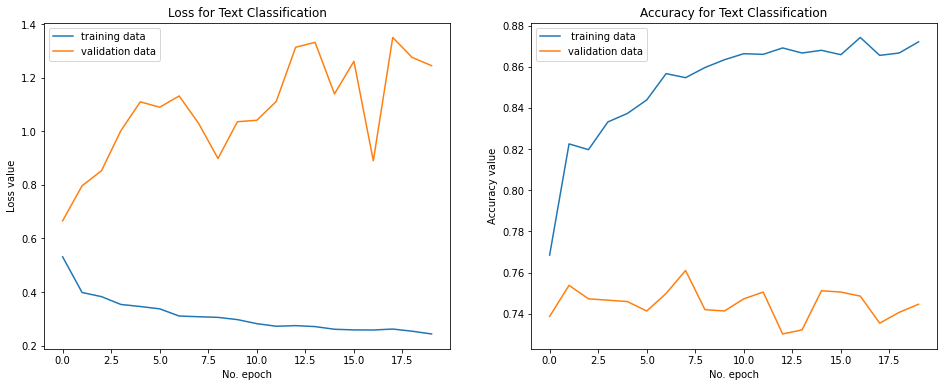

In [119]:
plt.figure(figsize=(16,6))
## Loss vs Epochs for train and validation data
plt.subplot(1,2,1)
plt.plot(results_bi_lstm.history['loss'], label='training data')
plt.plot(results_bi_lstm.history['val_loss'], label='validation data')
plt.title('Loss for Text Classification')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")


## Accuracy vs Epochs for train and validation data
plt.subplot(1,2,2)
plt.plot(results_bi_lstm.history['Accuracy'], label=' training data')
plt.plot(results_bi_lstm.history['val_Accuracy'], label='validation data')
plt.title('Accuracy for Text Classification')
plt.ylabel('Accuracy value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")

plt.show()

## 2) GRU

In [149]:
model_gru = tf.keras.Sequential()
model_gru.add(hub_layer)
model_gru.add(tf.keras.layers.Reshape((50, 1)))    ## Embeddings are of dimension 50
model_gru.add(Bidirectional(GRU(100, return_sequences=True)))
model.add(Flatten())
model_bi_lstm.add(Dropout(0.5))
model_gru.add(Dense(6, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_gru.add(Dropout(0.4))
model_gru.add(Dense(4, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_gru.add(Dropout(0.4))
model_gru.add(Dense(1,activation = 'sigmoid'))

In [150]:
model_gru.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 50)                48190600  
_________________________________________________________________
reshape_21 (Reshape)         (None, 50, 1)             0         
_________________________________________________________________
bidirectional_27 (Bidirectio (None, 50, 200)           61800     
_________________________________________________________________
dense_52 (Dense)             (None, 50, 6)             1206      
_________________________________________________________________
dropout_53 (Dropout)         (None, 50, 6)             0         
_________________________________________________________________
dense_53 (Dense)             (None, 50, 4)             28        
_________________________________________________________________
dropout_54 (Dropout)         (None, 50, 4)           

In [151]:
model_gru.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer='adam', metrics=['Accuracy'])

In [152]:
epochs =10
results_gru=model_gru.fit(X_train, y_train, batch_size=128,
                 epochs=epochs,
                 validation_data=(X_val,y_val),
                 verbose=1)

Epoch 1/10
48/48 [==============================] - 5s 37ms/step - loss: 0.7661 - Accuracy: 0.6908 - val_loss: 0.7482 - val_Accuracy: 0.6335
Epoch 2/10
48/48 [==============================] - 1s 26ms/step - loss: 0.6191 - Accuracy: 0.8431 - val_loss: 0.7219 - val_Accuracy: 0.7182
Epoch 3/10
48/48 [==============================] - 1s 24ms/step - loss: 0.5452 - Accuracy: 0.8738 - val_loss: 0.6450 - val_Accuracy: 0.7442
Epoch 4/10
48/48 [==============================] - 1s 24ms/step - loss: 0.5347 - Accuracy: 0.8568 - val_loss: 0.8074 - val_Accuracy: 0.7251
Epoch 5/10
48/48 [==============================] - 1s 23ms/step - loss: 0.4885 - Accuracy: 0.8832 - val_loss: 0.7967 - val_Accuracy: 0.7401
Epoch 6/10
48/48 [==============================] - 1s 24ms/step - loss: 0.4981 - Accuracy: 0.8582 - val_loss: 0.6834 - val_Accuracy: 0.7410
Epoch 7/10
48/48 [==============================] - 1s 23ms/step - loss: 0.4829 - Accuracy: 0.8687 - val_loss: 0.7481 - val_Accuracy: 0.7436
Epoch 8/10
48

In [83]:
model_gru.evaluate(X_val,y_val)

48/48 [==============================] - 0s 6ms/step - loss: 0.9834 - Accuracy: 0.7544


[0.9833686351776123, 0.7544320225715637]

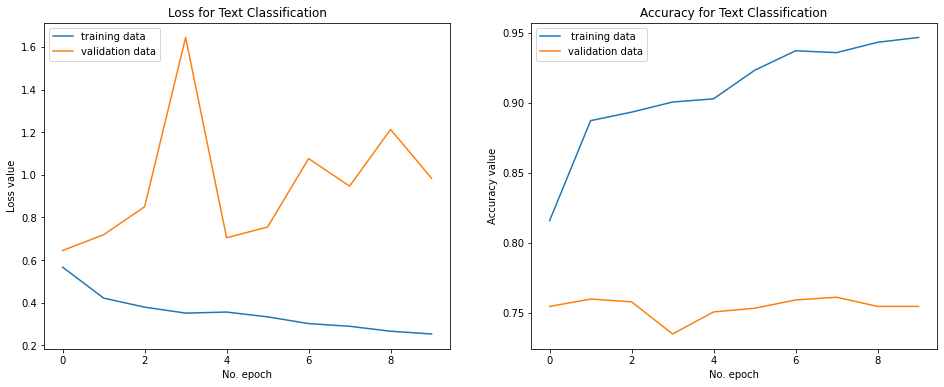

In [85]:
plt.figure(figsize=(16,6))
## Loss vs Epochs for train and validation data
plt.subplot(1,2,1)
plt.plot(results_gru.history['loss'], label='training data')
plt.plot(results_gru.history['val_loss'], label='validation data')
plt.title('Loss for Text Classification')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")


## Accuracy vs Epochs for train and validation data
plt.subplot(1,2,2)
plt.plot(results_gru.history['Accuracy'], label=' training data')
plt.plot(results_gru.history['val_Accuracy'], label='validation data')
plt.title('Accuracy for Text Classification')
plt.ylabel('Accuracy value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")

plt.show()